# Lecture 2: Computational Thinking with Python

## Exercise 2: Chemical Equation Balancer Checker

**Objective:** Write a program that checks if a chemical equation is balanced.

**Problem:** Create a function called `is_balanced()` that takes a chemical equation string and returns True if balanced, False if not.

**Your Task:**
- Split the equation at the arrow symbol "→" to get reactants and products
- For each side, parse the molecules and their coefficients
- Count total atoms of each element on both sides
- Compare the totals

Example Equation Format: "2H2 + O2 → 2H2O"

**Hints:**

- Use equation.split("→") to separate reactants from products
- Use side.split(" + ") to separate individual molecules
- You'll need to handle coefficients (numbers in front of molecules)
- Reuse your parse_molecular_formula() function from Exercise 1!
- For molecules with coefficients like "2H2O", the coefficient applies to all atoms in that molecule

**Steps to Think Through:**

- How do you extract the coefficient from "2H2O"? (It's everything before the first letter)
- How do you multiply the atom counts by the coefficient?
- How do you combine counts from multiple molecules on the same side?


Notes on strategy:

2H2O => 2 * H2O

H2O  => 1 * H2O

{'Ca': 1, 'Cl': 222}

{'H': 1, 'Ca': 3}

--> need to merge the dicts by the count of molecules

Strategy:
- Make one dict for reagents
- Make one dict for products
- See if they are the same
- Requires a multiplier function to apply the coefficients!

In [1]:
# Re-use solution from exercise 1

import re
from collections import defaultdict

def convert_quantities(quantity : str):
    if len(quantity) == 0:
        return 1
    else:
        return int(quantity)

def parse_molecular_formula(formula: str) -> dict[str, int]:
    """
    Because there is "N", "I" and "Ni" in elements, to split this in a unique way we require the correct capitalization in the input.
    """
    atom_dict = defaultdict(int)
    pattern = r"([A-Z][a-z]?)([0-9]*)"

    components = re.findall(pattern, formula)
    for component in components:
        atom_dict[component[0]] += convert_quantities(component[1])

    return atom_dict

In [2]:
def apply_multiplier(atoms : dict, multiplier: int):
    for atom, value in atoms.items():
        atoms[atom] = value * multiplier
    return atoms

In [3]:
def split_equation(chem_eq : str, verbose=False):
    left_side = chem_eq.split("→")[0]
    reagents = left_side.split("+")
    if verbose:
        print("reagents: ")
        print(reagents)
    
    right_side = chem_eq.split("→")[1]
    products = right_side.split("+")
    if verbose:
        print("products: ")
        print(products)
    return reagents, products

def split_sides_into_amounts(chemicals: str):
    chemical_dict = defaultdict(int)
    pattern = r"([0-9]*)(.+)"
    
    # Use convert_quantities and parse_molecular_formula functions defined in prior exercise above
    for chemical in chemicals:
        chemical = chemical.strip()
        matches_r = re.findall(pattern, chemical)
        multiplier_r = convert_quantities(matches_r[0][0])
        chemical_atoms = parse_molecular_formula(chemical)
        chemical_atoms = apply_multiplier(chemical_atoms, multiplier_r)
        for atom_r, value_r in chemical_atoms.items():
            chemical_dict[atom_r] += value_r

    return chemical_dict

def is_balanced(chem_eq : str, verbose=False):
    reagents, products = split_equation(chem_eq, verbose)    
    return split_sides_into_amounts(reagents) == split_sides_into_amounts(products)

chem_eq = "2H2 +      O2 + CH4 → 2H2O + CH4"
is_balanced(chem_eq)

True

In [4]:
is_balanced(chem_eq, verbose=True)

reagents: 
['2H2 ', '      O2 ', ' CH4 ']
products: 
[' 2H2O ', ' CH4']


True

### Test Cases


In [5]:
# If the outcome is incorrect, the keyword assert will cause an error

print(is_balanced("2H2 + O2 → 2H2O"))
assert is_balanced("2H2 + O2 → 2H2O")

print(is_balanced("H2 + O2 → H2O"))
assert not is_balanced("H2 + O2 → H2O")

print(is_balanced("CH4 + 2O2 → CO2 + 2H2O"))
assert is_balanced("CH4 + 2O2 → CO2 + 2H2O")

print(is_balanced("N2 + H2 → NH3"))
assert not is_balanced("N2 + H2 → NH3")

True
False
True
False


## Exercise 3: Reaction Pathway Analyzer

**Objective:** Analyze multi-step reaction sequences to find synthesis pathways.

**Problem:** Write a program that determines what compounds can be synthesized from starting materials through a series of reactions, and finds a pathway to create a target compound.

**Your Task:**
Create a function called `find_synthesis_path()` that takes:

- A list of starting compounds
- A list of reaction equations
- A target compound to synthesize

The function should return either:

- A list of reaction steps that lead to the target compound, OR
- A message saying the target cannot be synthesized

**Hints:**

- Start by creating a set of "available" compounds (your starting materials)
- For each reaction, check if you have all the reactants needed
- If you can perform a reaction, add the products to your available compounds
- Keep track of which reactions you've used in what order
- Continue until you either find the target or can't make any new compounds

#### Computational Thinking:

**Decomposition:** Break this into smaller problems

- Parse reaction equations
- Track available compounds
- Check if reactions can be performed
- Record the synthesis pathway


**Pattern Recognition:** What patterns do you see?

- Each reaction has the same format: "reactants → products"
- You need to repeatedly check if new reactions become possible


**Algorithm Design:** What's your step-by-step approach?

- Initialize available compounds
- Loop: try each reaction, see if possible, update available compounds
- Stop when target is found or no progress is made


**Abstraction:** What functions might be helpful?

- A function to parse a single reaction equation
- A function to check if a reaction is possible with current compounds
- A function to update available compounds after a reaction



Insights:
- We can try all reactions from stock and add products to stock if we can do a reaction
- Once we have accessed a reaction, we don't need to access it again, but we may track the sequence in which it was accessed (path)
- Some reactions may be inaccessible or irrelevant to making the target

Two commonly used search strategies:
- Breadth first --> the first example is something like a breadth-first search with secret doorways
    - Assign each reaction a number in the order it was done
    - Assign the stock products the same number as the reaction that produced them
    - It still might be that we visit a reaction that turns out to be unnecessary.
    - We record the parentage of each reaction and use this to backtrack to the necessary reactions if the target is reached.
- Depth first --> the second solution, which is a bit like wall following in a maze

### Examples

The "breadth-first search with secret doorways" strategy is something like this, where (left) grey arrows indicate "peeking", the black arrows indicate paths taken, and (right) the orange arrows indicate the reconstruction of the path to the target.

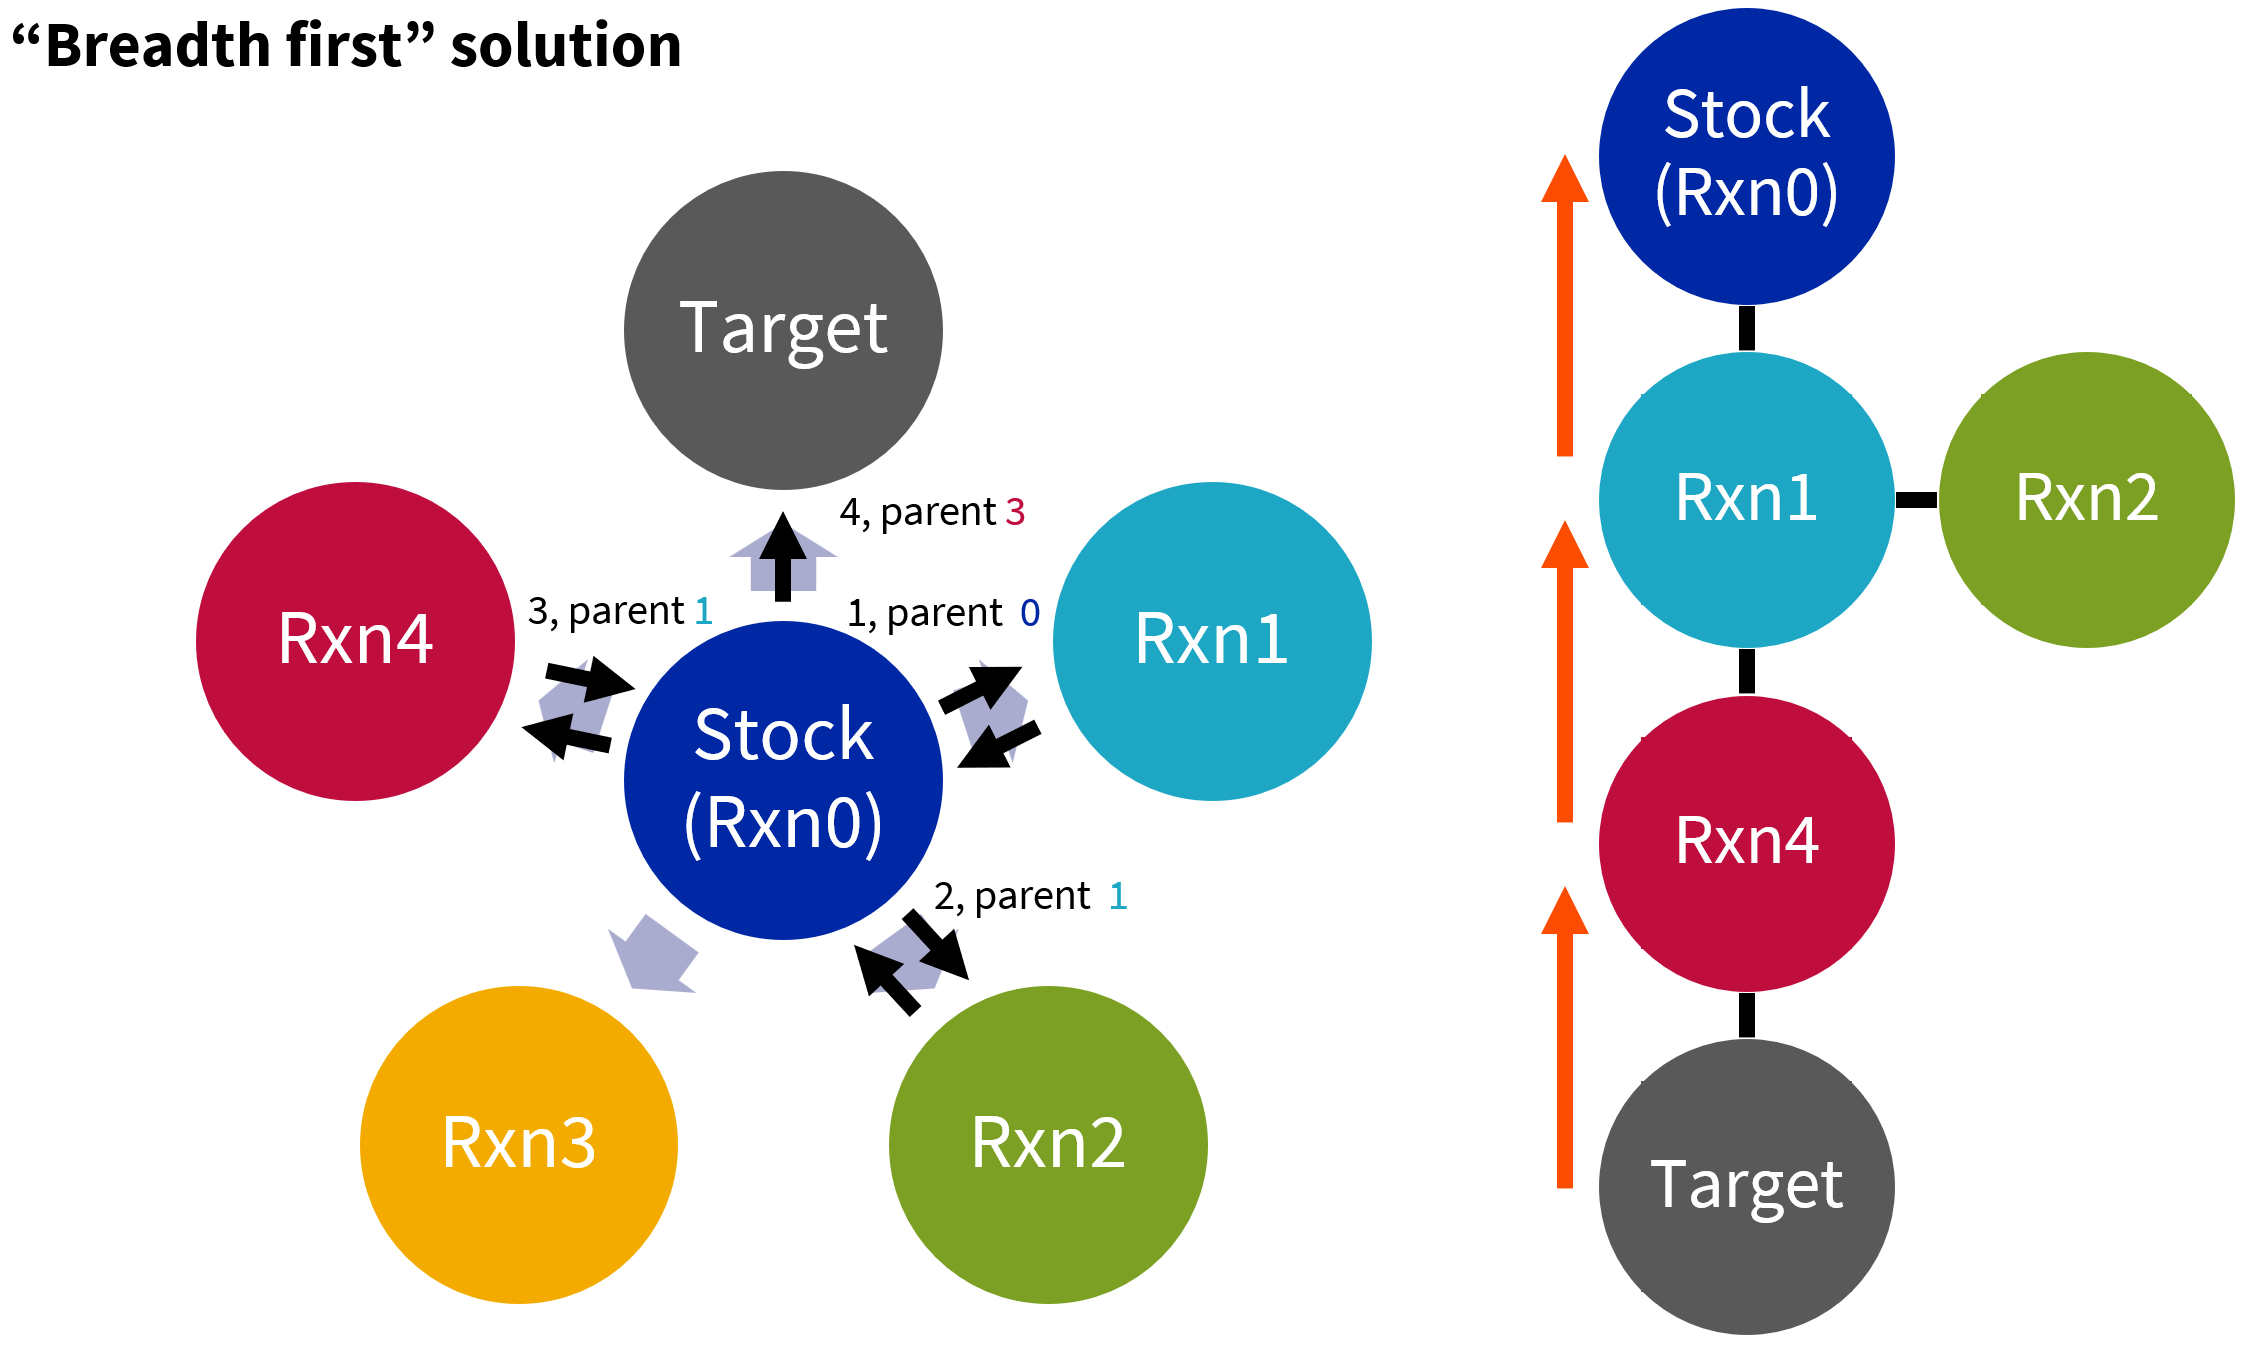
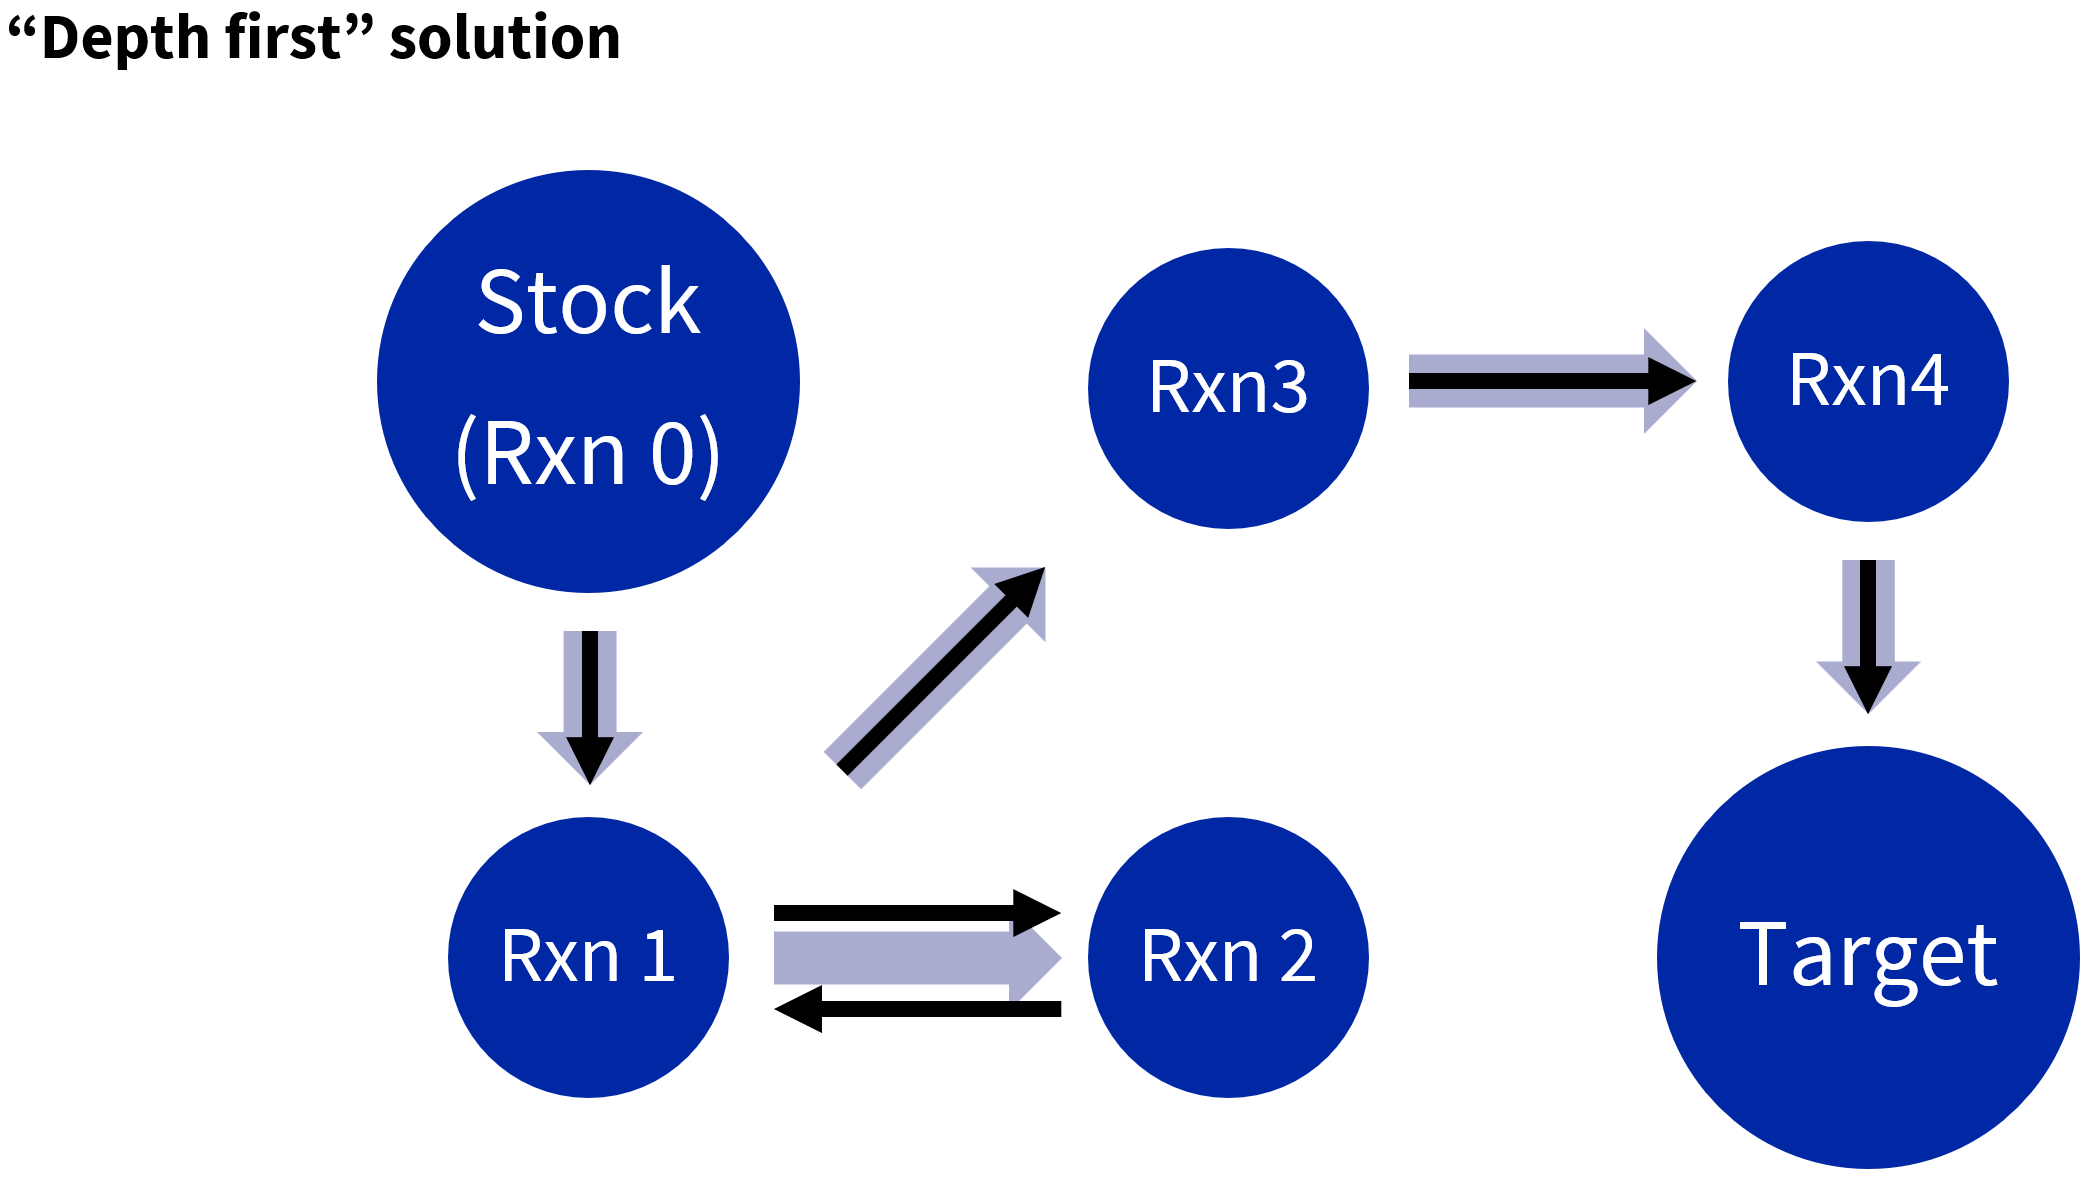

In [6]:
# Both solutions require the following dataclass and helper functions (as well as import re)

from dataclasses import dataclass
# A dataclass is a nicely packaged object that keeps data together.

@dataclass 
class Reaction:
    reagents : list[str]
    products : list[str]
    full_string : str
    order : int = 0
    parent = None
    used : bool = None

def split_molecules(molecules : str):
    pattern = r"[0-9]*([^+ ]+)" # an optional number, followed by the molecule which does not contain a space or `+` character
    return re.findall(pattern, molecules)
    
def split_reaction(reaction : str):
    reagents, products = reaction.split("→")
    reagent_molecules = split_molecules(reagents)
    product_molecules = split_molecules(products)
    
    return reagent_molecules, product_molecules


In [7]:
# "breadth first" solution

def find_synthesis_path_broad(starting_materials: list[str], reactions: list[str], target: str) -> list[str] | str:

    parsed_reactions = []
    
    for reaction in reactions:
        reagent_molecules, product_molecules = split_reaction(reaction)
        parsed_reaction = Reaction(reagent_molecules, product_molecules, reaction, order=0)
        parsed_reactions.append(parsed_reaction)
    
    starting_materials = set(starting_materials)
    order = 1
    parent = "Stock"
    poof = True

    while poof:
        poof = False
        for parsed_reaction in parsed_reactions:
            if parsed_reaction.order != 0:
                # this has been used, do not use again
                continue
            if set(parsed_reaction.reagents).issubset(starting_materials):
                starting_materials = starting_materials.union(set(parsed_reaction.products))
                parsed_reaction.order = order
                parsed_reaction.parent = parent
                order += 1
                poof = True
                parent = parsed_reaction
                break

    if target in starting_materials:
        print("Target can be synthesized.")
        for parsed_reaction in parsed_reactions:
            if target in set(parsed_reaction.products):
                # print(parsed_reaction.full_string)
                # print(parsed_reaction.parent)
                parent_chain(parsed_reaction)
                break
    else:
        print("Target cannot be synthesized.")

def parent_chain(parsed_reaction : Reaction):
    if parsed_reaction != "Stock":
        print(parsed_reaction.full_string, end="")
        print(" <==> ", end="")
        if parsed_reaction.parent is not None:
            parent_chain(parsed_reaction.parent)
    elif parsed_reaction == "Stock":
        print("Stock")



In [8]:
# "depth first" solution

def find_synthesis_path_deep(starting_materials : list[str], reactions : list[str], target: str):
    
    reactions.insert(0, "→" + "+".join(starting_materials)) # Make stock look like reaction products for consistency

    parsed_reactions = []
    for reaction in reactions:
        reagent_molecules, product_molecules = split_reaction(reaction)
        parsed_reaction = Reaction(reagent_molecules, product_molecules, reaction,)
        parsed_reactions.append(parsed_reaction)

    if find_reaction(target, parsed_reactions): #This is recursive
        return True, [reaction.full_string for reaction in parsed_reactions if reaction.used]
    else:
        return False, []

def find_reaction(target: str, parsed_reactions: list[Reaction]):
    if (target == ""):
        return True

    for reaction in parsed_reactions:
        if target in set(reaction.products): # this is a potential reaction path
            if reaction.used: # we have used this reaction already and it was reachable
                return True
            # a potential path to synthesize this target, it is a working path if we can get all reageants:                       
            elif all(find_reaction(reagent, parsed_reactions) for reagent in reaction.reagents): 
                reaction.used = True # tag this reactions as used in the synthesis
                return True
    
    return False

### Test Cases

In [9]:
# Basic Multi-Step Synthesis

starting_materials = ["H2", "O2", "N2"]

reactions = [
    "2H2 + O2 → 2H2O",
    "N2 + 3H2 → 2NH3", 
    "NH3 + H2O → NH4OH"
]

target = "NH4OH"


In [10]:
find_synthesis_path_broad(starting_materials, reactions, target)
find_synthesis_path_deep(starting_materials, reactions, target)

Target can be synthesized.
NH3 + H2O → NH4OH <==> N2 + 3H2 → 2NH3 <==> 2H2 + O2 → 2H2O <==> Stock


(True,
 ['→H2+O2+N2', '2H2 + O2 → 2H2O', 'N2 + 3H2 → 2NH3', 'NH3 + H2O → NH4OH'])

In [11]:
# Direct Synthesis (One Step)

starting_materials = ["Na", "Cl2"]
reactions = [
    "2Na + Cl2 → 2NaCl",
    "NaCl + H2O → NaOH + HCl"
]
target = "NaCl"

find_synthesis_path_broad(starting_materials, reactions, target)
find_synthesis_path_deep(starting_materials, reactions, target)
# Expected: Should find direct synthesis in one step

Target can be synthesized.
2Na + Cl2 → 2NaCl <==> Stock


(True, ['→Na+Cl2', '2Na + Cl2 → 2NaCl'])

In [12]:
# Impossible Synthesis

starting_materials = ["H2", "O2"]
reactions = [
    "2H2 + O2 → 2H2O",
    "N2 + 3H2 → 2NH3"  # But we don't have N2!
]
target = "NH3"

find_synthesis_path_broad(starting_materials, reactions, target)
find_synthesis_path_deep(starting_materials, reactions, target)
# Expected: Should return message that NH3 cannot be synthesized

Target cannot be synthesized.


(False, [])

In [13]:
# Multiple Pathway Options
starting_materials = ["C", "H2", "O2", "H2O"]
reactions = [
    "C + O2 → CO2",
    "2H2 + O2 → 2H2O",
    "CO2 + H2O → H2CO3",
    "C + 2H2 → CH4",
    "CH4 + 2O2 → CO2 + 2H2O"
]
target = "CO2"

find_synthesis_path_broad(starting_materials, reactions, target)
find_synthesis_path_deep(starting_materials, reactions, target)
# Expected: Should find one of multiple possible paths to CO2

Target can be synthesized.
C + O2 → CO2 <==> Stock


(True, ['→C+H2+O2+H2O', 'C + O2 → CO2'])

In [14]:
# Long Chain Synthesis
starting_materials = ["Fe", "O2", "C"]
reactions = [
    "4Fe + 3O2 → 2Fe2O3",
    "2C + O2 → 2CO",
    "Fe2O3 + 3CO → 2Fe + 3CO2",
    "CO2 + C → 2CO"
]
target = "CO2"

find_synthesis_path_broad(starting_materials, reactions, target)
find_synthesis_path_deep(starting_materials, reactions, target)
# Expected: Should find the multi-step path involving iron oxide formation and reduction

Target can be synthesized.
Fe2O3 + 3CO → 2Fe + 3CO2 <==> 2C + O2 → 2CO <==> 4Fe + 3O2 → 2Fe2O3 <==> Stock


(True,
 ['→Fe+O2+C',
  '4Fe + 3O2 → 2Fe2O3',
  '2C + O2 → 2CO',
  'Fe2O3 + 3CO → 2Fe + 3CO2'])